In [1]:
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

# from tensorflow.keras.applications import Densnet
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import tensorflow.keras as keras
from tensorflow.data import Dataset

from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from itertools import product
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from wandb.keras import WandbCallback

2022-06-14 15:53:04.715157: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import wandb
wandb.init(project='smartpot',
          config = {
                    'learning_rate': 1e-5,
                    'epochs': 10,
                    'batch_size': 30,
                    'drop_out' : 0.5,
                    'dense' : 1024
                })

config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hkleee. Use `wandb login --relogin` to force relogin


In [4]:
tf.__version__

'2.4.1'

In [5]:
IMAGE_SIZE = 320
MODEL_IMAGE_SIZE = 224

# Data Load

In [6]:
df = pd.read_csv('../data/small_down_sampled_strawberry.csv')
df.head()

,image,disease,area,grow,points,original,disease-grow
0,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5,"[{'xtl': 1003, 'ytl': 1167, 'xbr': 2255, 'ybr'...",NaN,0-5
1,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5,"[{'xtl': 1003, 'ytl': 1217, 'xbr': 2503, 'ybr'...",NaN,0-5
2,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5,"[{'xtl': 370, 'ytl': 884, 'xbr': 1994, 'ybr': ...",NaN,0-5
3,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5,"[{'xtl': 739, 'ytl': 1184, 'xbr': 2176, 'ybr':...",NaN,0-5
4,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5,"[{'xtl': 1031, 'ytl': 1271, 'xbr': 2425, 'ybr'...",NaN,0-5


In [7]:
# label encoding
disease_encoder = LabelEncoder()
disease_encoder.fit(df['disease'])
df['disease'] = disease_encoder.transform(df['disease'] )

In [8]:
df['disease'].unique()

array([0, 1, 2])

In [9]:
shuffled_df = df.sample(frac=1)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df['image'].to_list(), 
                                                   df['disease-grow'].to_list(),
                                                   stratify=df['disease-grow'],
                                                   test_size=0.2)

In [11]:
train_df = df[df['image'].isin(x_train)]
valid_df = df[df['image'].isin(x_test)]
print(train_df.__len__())
train_df.head()

6796


,image,disease,area,grow,points,original,disease-grow
1,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5,"[{'xtl': 1003, 'ytl': 1217, 'xbr': 2503, 'ybr'...",NaN,0-5
2,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5,"[{'xtl': 370, 'ytl': 884, 'xbr': 1994, 'ybr': ...",NaN,0-5
3,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5,"[{'xtl': 739, 'ytl': 1184, 'xbr': 2176, 'ybr':...",NaN,0-5
4,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5,"[{'xtl': 1031, 'ytl': 1271, 'xbr': 2425, 'ybr'...",NaN,0-5
5,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5,"[{'xtl': 811, 'ytl': 1132, 'xbr': 2351, 'ybr':...",NaN,0-5


In [12]:
train_gen = ImageDataGenerator(rescale=1./255,
                            rotation_range=20, # 최대 20도까지 회전
                            width_shift_range=0.1, # 최대 x 범위안에서 좌우/상하 이동
                            height_shift_range=0.1,
                            zoom_range=0.2, # 확대 축소 비율,
                            horizontal_flip=True, # 좌우반전
                            vertical_flip=True, # 상하반전
                            fill_mode='nearest')
valid_gen = ImageDataGenerator(rescale= 1. /255.)

In [13]:
train_generator = train_gen.flow_from_dataframe(train_df,
                                               x_col='image',
                                               y_col='disease',
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               class_mode='raw',
                                               batch_size=config.batch_size)
valid_generator = valid_gen.flow_from_dataframe(valid_df,
                                               x_col='image',
                                               y_col='disease',
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               class_mode='raw',
                                               batch_size=config.batch_size)

Found 6796 validated image filenames.
Found 1700 validated image filenames.


In [14]:
## pretrain_net
base_model= resnet50.ResNet50(
          weights='imagenet',
          include_top=False,
         )


base_model.trainable = False 

2022-06-14 15:53:12.204780: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-14 15:53:12.205884: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-14 15:53:12.249943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 15:53:12.250541: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-06-14 15:53:12.250584: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-14 15:53:12.256527: I tensorflow/stream_executor/platform/default/dso_loade

In [15]:
## resizing layer
input_data = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data)
resizing = Model(inputs=input_data, outputs=x, name='resize')

In [16]:
df['disease'].nunique()

3

In [17]:
tf.keras.backend.clear_session()

In [18]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = resizing(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(config.drop_out)(x)
backbone_out = layers.Dense(config.dense, activation='relu')(x)
outputs = layers.Dense(df['disease'].nunique(), activation='softmax')(backbone_out)

model = Model(inputs=inputs, 
              outputs=outputs,
              name='strawberry_disease')

In [19]:
model.summary()

Model: "strawberry_disease"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
resize (Functional)          (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 3)          

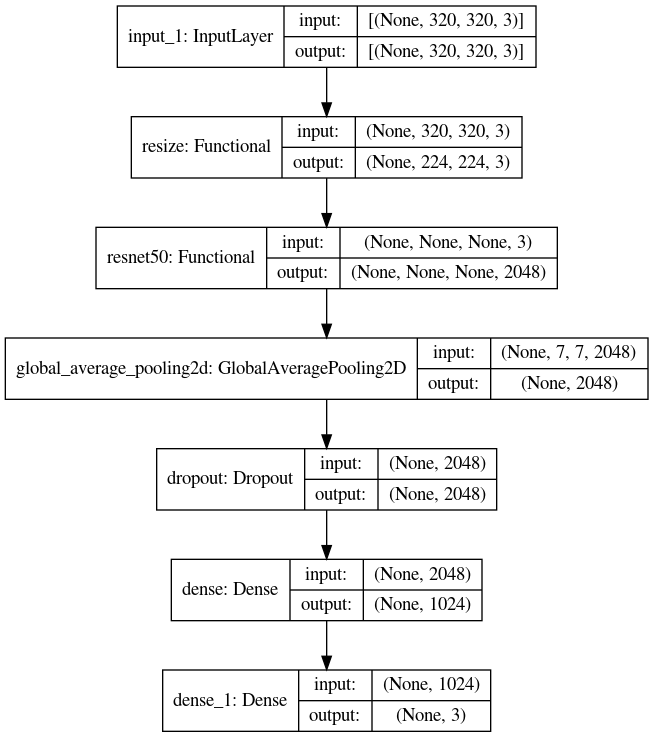

In [20]:
keras.utils.plot_model(model, show_shapes=True)

In [21]:
es = EarlyStopping(monitor='loss',
                mode='auto',
                patience=5,
                verbose=1)

ckpt_path = './checkpoints/single_resnet_strawberry/resnet50.ckpt'
checkpointer = ModelCheckpoint(filepath=ckpt_path,
                              monitor='val_loss',
                              save_weights_only = True,
                              save_best_only= True,
                              verbose=1)
auc = tf.keras.metrics.AUC()
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=config.learning_rate),
              metrics=['accuracy']) # 필요시 f1 score metrics custom

In [ ]:
history = model.fit(train_generator,
          validation_data=valid_generator,
          verbose=1,
          epochs=config.epochs,
          steps_per_epoch=len(train_df)//config.batch_size,
         callbacks=[es, checkpointer, WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2022-06-14 15:53:20.200320: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-14 15:53:20.219599: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/10


2022-06-14 15:53:22.618986: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-14 15:53:27.280393: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


226/226 [==============================] - 1315s 6s/step - loss: 1.1910 - accuracy: 0.3625 - val_loss: 1.0693 - val_accuracy: 0.4206

Epoch 00001: val_loss improved from inf to 1.06926, saving model to ./checkpoints/single_resnet_strawberry/resnet50.ckpt
Epoch 2/10
226/226 [==============================] - 1284s 6s/step - loss: 1.1072 - accuracy: 0.3862 - val_loss: 1.0625 - val_accuracy: 0.4206

Epoch 00002: val_loss improved from 1.06926 to 1.06252, saving model to ./checkpoints/single_resnet_strawberry/resnet50.ckpt
Epoch 3/10
226/226 [==============================] - 1267s 6s/step - loss: 1.1049 - accuracy: 0.3886 - val_loss: 1.0581 - val_accuracy: 0.4206

Epoch 00003: val_loss improved from 1.06252 to 1.05806, saving model to ./checkpoints/single_resnet_strawberry/resnet50.ckpt
Epoch 4/10
 55/226 [======>.......................] - ETA: 13:14 - loss: 1.0813 - accuracy: 0.4136

In [ ]:
wandb sweeper 